q_sol.shape = torch.Size([120, 3003])
qdot_sol.shape = torch.Size([120, 3003])


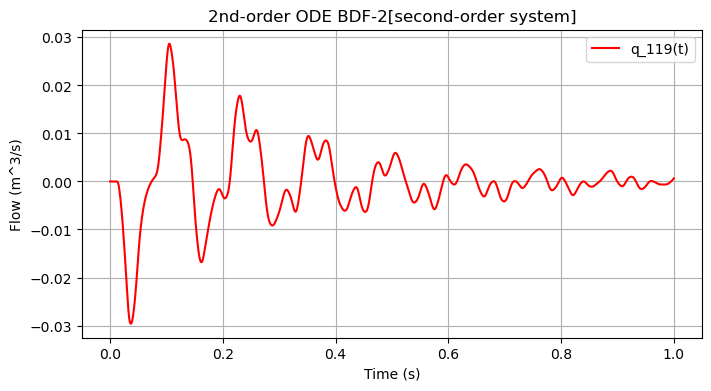

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

# --------------------------------
# 0) Basic constants and settings
# --------------------------------
torch.set_default_dtype(torch.float64)

# ----------------------------
# Normalization factors
# ----------------------------
Norm_U = (3e-4)
Norm_C = ((1e-10*3e-4))
Norm_L = ((3e-4)/1e-10) 
Norm_R = (1/1e-10)

partition1, partition2, partition3, partition4  = 30, 30, 30, 30
partition_tot = partition1 + partition2 + partition3 + partition4  # 120

sigma = 0.047
mu    = 0.0157
rho   = 1111.4
alpha = 0.29e-9
c     = 1600

r      = 235e-6
r_nozz = 25e-6
l1 = 0.012
l2 = 0.0084
l3 = 0.00542303
l4 = 0.00057697

# Characteristic time considering viscous effects
T_visc = 2*(l1 + l2 + l3 + l4)/c
delta_v = torch.sqrt(mu * T_visc / torch.tensor(math.pi) / rho)

# 1) Dividing radius and length by segment
ri = torch.tensor([r + (r_nozz - r)/partition4 * i for i in range(1, partition4+1)])
ri = torch.cat([r*torch.ones(partition_tot - partition4), ri])
li = torch.cat([
    l1/partition1*torch.ones(partition1),
    l2/partition2*torch.ones(partition2),
    l3/partition3*torch.ones(partition3),
    l4/partition4*torch.ones(partition4)
])

# 2) State-space elements (cap, ind, res)
cap = (torch.pi*(ri**2)*li/(c**2)/rho) / Norm_C
cap[-1] = (torch.pi*(r_nozz**4)/3/sigma)/ Norm_C

ind = (rho*li/torch.pi/(ri**2)) / Norm_L
res = (2*mu*li/torch.pi/delta_v/(ri**3)) / Norm_R

# 3) Matrices needed for "second-order" differential equation
#    q''(t) = A * q(t) + B * q'(t) + f(t)
#    Here, A = L_mat * C_mat, B = R_mat
#
#    L_mat, C_mat, R_mat are constructed as follows
partition_N = partition_tot

# eye, zeros
I_N = torch.eye(partition_N)
Z_N = torch.zeros((partition_N, partition_N))

# L_mat
L_mat = torch.roll(I_N*(1.0/ind), -1, dims=1) - I_N*(1.0/ind)
L_mat[0, -1] = 0

# C_mat
C_mat = -torch.roll(I_N*(1.0/cap), 1, dims=1) + I_N*(1.0/cap)
C_mat[-1, 0] = 0

# R_mat
R_mat = -I_N*(res/ind)

A_mat = L_mat @ C_mat   # Term multiplied by q(t)
B_mat = R_mat           # Term multiplied by q'(t)


# 4) External force f(t) = f_2nd_bot
#    In the original code, f_2nd = [ 0; L_mat @ f_1st ]
#    ⇒ For our direct use, f_2nd_bot = L_mat @ f_1st
B_q_bot = torch.cat([
    torch.zeros(partition1,1),
    torch.ones(partition2,1),
    torch.zeros(partition3+partition4,1)
], dim=0)

T_ = torch.linspace(0, 1, 3002)  # 0 to 1 second, 3001 steps + 1
dt = T_[1] - T_[0]
nT = len(T_)

t1, t2, t3, V_max = 6e-2/3, 26-2/3, 32e-2/3, 30
dVdp = (
    V_max/t1*(1 - (T_ > t1).float())
    - V_max/(t3 - t2)*((T_ > t2).float() - (T_ > t3).float())
)

f_1st = -(-B_q_bot*(c**2)*rho*2*alpha*dVdp.reshape(1,-1)/r) * Norm_U

f_test = -(-(c**2)*rho*2*alpha*dVdp.reshape(1,-1)/r) * Norm_U


f_2nd_bot = L_mat @ f_1st  # (N, nT)

# 5) Initial conditions: q(0) & q'(0)
q_init   = torch.zeros(partition_N)
qdot_init= torch.zeros(partition_N)  # According to the problem setup, initial flow velocity = 0

# ----------------------------------------------------
# 6) (Important) Direct BDF-2 recursive function for a second-order differential system
# ----------------------------------------------------
def bdf2_solver_2nd_order(A, B, f_bot, q0, qdot0, dt):
    """
    Example function for directly solving the 2nd-order ODE
    q''(t) = A q(t) + B q'(t) + f(t)
    using BDF-2.

    Parameters
    ----------
    A : torch.Tensor, shape=(N,N)
    B : torch.Tensor, shape=(N,N)
    f_bot : torch.Tensor, shape=(N, nT)  # Forced term (vector) at each time
    q0 : torch.Tensor, shape=(N,)       # Initial q(0)
    qdot0 : torch.Tensor, shape=(N,)    # Initial q'(0)
    dt : float

    Returns
    -------
    q_hist : (N, nT+1)      # q(t_n) at each step
    qdot_hist : (N, nT+1)   # q'(t_n) at each step
    """
    N, nT = f_bot.shape
    # For storing results
    q_hist    = torch.zeros((N, nT+1), dtype=A.dtype, device=A.device)
    qdot_hist = torch.zeros((N, nT+1), dtype=A.dtype, device=A.device)

    # Record the initial conditions
    q_hist[:, 0]    = q0
    qdot_hist[:, 0] = qdot0

    # The first step (t=dt) requires x_{-1} for BDF-2
    # Usually, "2nd-order implicit integration" (or another 1-step method) is used to approximate q_1, qdot_1
    # Here, we simply try a "Backward Euler"-like approach for q_1:
    #   q''(t_0) ~ A q0 + B qdot0 + f(0)
    #   q'(t_0+dt) ~ qdot0 + dt*q''(t_0)
    #   q(t_0+dt)  ~ q0 + dt*q'(t_0+dt)
    f0       = f_bot[:, 0]  # shape=(N,)
    qddot0   = A @ q0 + B @ qdot0 + f0
    qdot_1   = qdot0 + dt * qddot0
    q_1      = q0 + dt * qdot_1

    q_hist[:, 1]    = q_1
    qdot_hist[:, 1] = qdot_1

    # Now, apply BDF-2 in earnest
    # BDF-2:
    #   (3 x_n - 4 x_{n-1} + x_{n-2}) / (2dt) = x'_n
    #   (3 x'_n - 4 x'_{n-1} + x'_{n-2}) / (2dt) = x''_n
    #
    # where x=q, x'=q', x''=q''= A q + B q' + f
    #
    # => We must formulate the equation for q_n (implicit).
    #    (Here, a straightforward direct approach is shown.)
    
    # Store previous steps
    q_nm2    = q0
    q_nm1    = q_1
    qdot_nm2 = qdot0
    qdot_nm1 = qdot_1

    # Time loop
    for i_step in range(2, nT+1):
        # External force at this step
        f_i = f_bot[:, i_step-1]  # shape=(N,)

        # Unknowns to solve for: q_n and qdot_n
        # 
        # (1) BDF-2 approximation: qdot_n = (3 q_n - 4 q_{n-1} + q_{n-2}) / (2dt)
        # (2) Another BDF-2 approximation: q''_n = (3 qdot_n - 4 qdot_{n-1} + qdot_{n-2}) / (2dt)
        #                                = A q_n + B qdot_n + f_i
        #
        # By combining the above, we can obtain a matrix form in q_n.
        #
        # (See the comments below for more detailed steps.)
        
        # 1) qdot_n = (3/2dt)*q_n + constant
        alpha   = 3.0/(2.0*dt)
        const_q = (-4.0/(2.0*dt))*q_nm1 + (1.0/(2.0*dt))*q_nm2

        # 2) q''_n = A q_n + B qdot_n + f_i
        #    Another BDF-2 form:
        #    q''_n = (3 qdot_n - 4 qdot_nm1 + qdot_nm2) / (2 dt)
        beta    = 3.0/(2.0*dt)
        const_d = (-4.0/(2.0*dt))*qdot_nm1 + (1.0/(2.0*dt))*qdot_nm2

        # Then:
        #   (3 qdot_n - 4 qdot_nm1 + qdot_nm2)/(2 dt) = A q_n + B qdot_n + f_i
        #
        #   beta*(alpha q_n + const_q) + const_d = A q_n + B*(alpha q_n + const_q) + f_i
        #   => (beta*alpha) q_n + beta*const_q + const_d = A q_n + B*alpha q_n + B*const_q + f_i
        #
        #   Collect terms in q_n:
        #   (beta*alpha - A - B*alpha) q_n = - (beta * const_q + const_d) + B*const_q - f_i
        #
        #   M_q = beta*alpha * I - A - alpha*B
        #   rhs = - (beta * const_q + const_d) + B@const_q - f_i
        #
        M_q  = beta*alpha * I_N - A - alpha*B
        rhs  = - (beta * const_q + const_d) + (B @ const_q) - f_i

        # Solve for q_n = M_q^-1 * rhs
        q_n = torch.linalg.solve(M_q, rhs)

        # qdot_n = alpha * q_n + const_q
        qdot_n = alpha * q_n + const_q

        # Save in storage
        q_hist[:, i_step]    = q_n
        qdot_hist[:, i_step] = qdot_n

        # Use the current step results as past values for the next loop
        q_nm2    = q_nm1
        q_nm1    = q_n
        qdot_nm2 = qdot_nm1
        qdot_nm1 = qdot_n

    return q_hist, qdot_hist


# -----------------------------------------------------
# 7) Solve the second-order ODE using BDF-2
# -----------------------------------------------------
q_sol, qdot_sol = bdf2_solver_2nd_order(
    A_mat, B_mat, f_2nd_bot,
    q_init, qdot_init, dt
)

print("q_sol.shape =", q_sol.shape)       # (N, nT+1), N=120, nT=3002
print("qdot_sol.shape =", qdot_sol.shape) # (N, nT+1)

# 8) Example: plot the flow at a specific index
i_q = 119
q_2nd_all = q_sol[i_q, :].detach().cpu().numpy()  # length = nT+1 = 3003
# Exclude the very first value (q(0)) and consider from t=dt
q_2nd = q_2nd_all[1:]   # (3002 elements)

T_plot = T_.numpy()     # 3002 time points, including the initial 0s
plt.figure(figsize=(8,4))
plt.plot(T_plot, q_2nd, 'r-', label=f"q_{i_q}(t)")
plt.title("2nd-order ODE BDF-2[second-order system]")
plt.xlabel("Time (s)")
plt.ylabel("Flow (m^3/s)")
plt.grid(True)
plt.legend()
plt.show()



q_sol.shape   = torch.Size([120, 3003])
qdot_sol.shape= torch.Size([120, 3003])


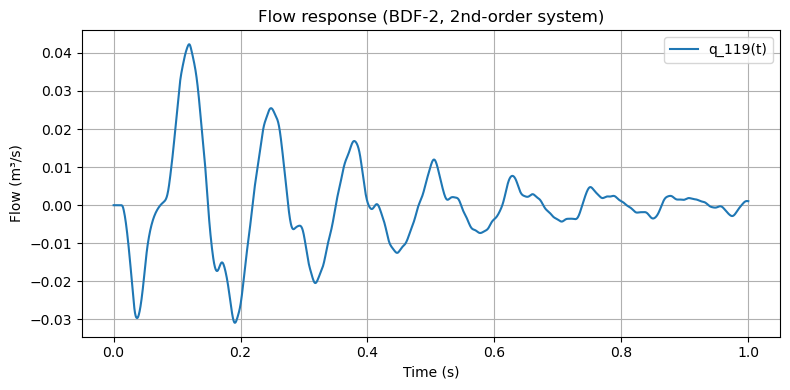

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

# --------------------------------
# 0) Basic constants and settings
# --------------------------------
torch.set_default_dtype(torch.float64)

# ----------------------------
# Normalization factors
# ----------------------------
Norm_U = 3e-4
Norm_C = 1e-10 * 3e-4
Norm_L = (3e-4) / 1e-10
Norm_R = 1 / 1e-10

# ----------------------------
# Geometry and partitions
# ----------------------------
partition1, partition2, partition3, partition4 = 30, 30, 30, 30
partition_tot = partition1 + partition2 + partition3 + partition4  # =120

sigma = 0.047
mu    = 0.0157
rho   = 1111.4
alpha = 0.29e-9
c     = 1600

r      = 235e-6
r_nozz = 25e-6
l1, l2, l3, l4 = 0.012, 0.0084, 0.00542303, 0.00057697

# Characteristic time considering viscous effects
T_visc = 2*(l1 + l2 + l3 + l4) / c
delta_v = torch.sqrt(mu * T_visc / torch.tensor(math.pi) / rho)

# 1) Radius & length for each segment
ri = torch.tensor([r + (r_nozz - r)/partition4 * i for i in range(1, partition4+1)])
ri = torch.cat([r * torch.ones(partition_tot - partition4), ri])

li = torch.cat([
    l1/partition1 * torch.ones(partition1),
    l2/partition2 * torch.ones(partition2),
    l3/partition3 * torch.ones(partition3),
    l4/partition4 * torch.ones(partition4)
])

# 2) State-space elements (cap, ind, res)
cap = (torch.pi * ri**2 * li / (c**2) / rho) / Norm_C
cap[-1] = (torch.pi * r_nozz**4 / (3 * sigma)) / Norm_C

ind = (rho * li / (torch.pi * ri**2)) / Norm_L
res = (2 * mu * li / (torch.pi * delta_v * ri**3)) / Norm_R

# 3) Matrices for second-order ODE  q'' = A q + R q' + f
N = partition_tot
I_N = torch.eye(N)
Z_N = torch.zeros((N, N))

L_mat = torch.roll(I_N * (1.0 / ind), -1, dims=1) - I_N * (1.0 / ind)
L_mat[0, -1] = 0.0

C_mat = -torch.roll(I_N * (1.0 / cap), 1, dims=1) + I_N * (1.0 / cap)
C_mat[-1, 0] = 0.0

R_mat = -I_N * (res / ind)

A_mat = L_mat @ C_mat      # coefficient on q
B_mat = R_mat              # coefficient on q'  (기존 이름 유지)

# ----------------------------------------------------
# 4) External-force distribution masks  (★ NEW ★)
# ----------------------------------------------------
B_mat1 = torch.cat([
    torch.zeros(partition1, 1),
    torch.ones(partition2, 1),          # only partition2
    torch.zeros(partition3 + partition4, 1)
], dim=0)                               # shape (120,1)

B_mat2 = torch.ones(partition_tot, 1)   # whole channel

# 선택: 공급압력이 작용할 구간
B_q_bot = B_mat1        # ← partition2 만
# B_q_bot = B_mat2      # ← 전체 구간

# ----------------------------------------------------
# 5) Time-varying forcing term
# ----------------------------------------------------
T_  = torch.linspace(0.0, 1.0, 3002)   # 0-1 s, 3001 Δt + t=0
dt  = T_[1] - T_[0]
nT  = len(T_)

t1, t2, t3, V_max = 6e-2/3, 26e-2/3, 32e-2/3, 30.0
dVdp = (
    V_max / t1 * (1 - (T_ > t1).float())
    - V_max / (t3 - t2) * ((T_ > t2).float() - (T_ > t3).float())
)

f_1st      = -(-B_q_bot * (c**2) * rho * 2 * alpha * dVdp.reshape(1, -1) / r) * Norm_U
f_2nd_bot  = L_mat @ f_1st            # shape (120, nT)

# 6) Initial conditions
q_init    = torch.zeros(N)
qdot_init = torch.zeros(N)

# ----------------------------------------------------
# 7) BDF-2 solver (2nd-order system)
# ----------------------------------------------------
def bdf2_solver_2nd_order(A, B, f_bot, q0, qdot0, dt):
    N, nT = f_bot.shape
    q_hist    = torch.zeros((N, nT+1), dtype=A.dtype)
    qdot_hist = torch.zeros((N, nT+1), dtype=A.dtype)

    q_hist[:, 0]    = q0
    qdot_hist[:, 0] = qdot0

    f0     = f_bot[:, 0]
    qddot0 = A @ q0 + B @ qdot0 + f0
    qdot_1 = qdot0 + dt * qddot0
    q_1    = q0    + dt * qdot_1

    q_hist[:, 1]    = q_1
    qdot_hist[:, 1] = qdot_1

    q_nm2, q_nm1    = q0, q_1
    qdot_nm2, qdot_nm1 = qdot0, qdot_1

    alpha = 3.0 / (2.0 * dt)
    beta  = 3.0 / (2.0 * dt)

    I_N = torch.eye(N, dtype=A.dtype)

    for i_step in range(2, nT+1):
        f_i = f_bot[:, i_step-1]

        const_q = (-4.0 / (2.0 * dt)) * q_nm1 + (1.0 / (2.0 * dt)) * q_nm2
        const_d = (-4.0 / (2.0 * dt)) * qdot_nm1 + (1.0 / (2.0 * dt)) * qdot_nm2

        M_q  = beta * alpha * I_N - A - alpha * B
        rhs  = -(beta * const_q + const_d) + (B @ const_q) - f_i

        q_n     = torch.linalg.solve(M_q, rhs)
        qdot_n  = alpha * q_n + const_q

        q_hist[:, i_step]    = q_n
        qdot_hist[:, i_step] = qdot_n

        q_nm2, q_nm1       = q_nm1, q_n
        qdot_nm2, qdot_nm1 = qdot_nm1, qdot_n

    return q_hist, qdot_hist

# ----------------------------------------------------
# 8) Solve
# ----------------------------------------------------
q_sol, qdot_sol = bdf2_solver_2nd_order(A_mat, B_mat, f_2nd_bot,
                                        q_init, qdot_init, dt)

print("q_sol.shape   =", q_sol.shape)     # (120, 3003)
print("qdot_sol.shape=", qdot_sol.shape)  # (120, 3003)

# ----------------------------------------------------
# 9) Plot example flow at nozzle exit (segment 119)
# ----------------------------------------------------
i_q = 119
q_2nd_all = q_sol[i_q, :].detach().cpu().numpy()
q_2nd     = q_2nd_all[1:]        # drop t=0

T_plot = T_.numpy()
plt.figure(figsize=(8, 4))
plt.plot(T_plot, q_2nd, label=f"q_{i_q}(t)")
plt.title("Flow response (BDF-2, 2nd-order system)")
plt.xlabel("Time (s)")
plt.ylabel("Flow (m³/s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


q_sol : torch.Size([120, 3003])   qdot_sol : torch.Size([120, 3003])


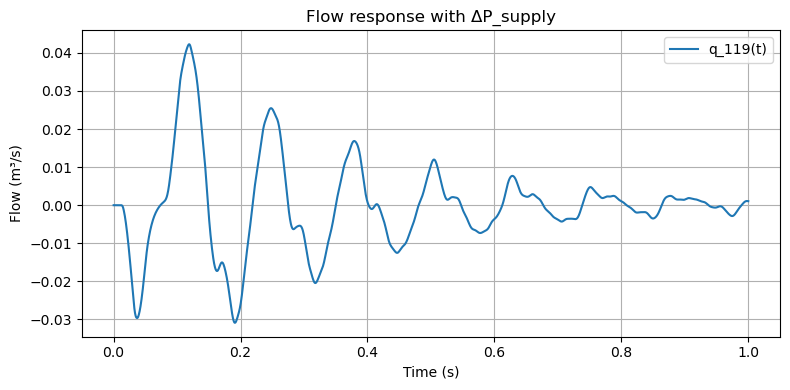

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

torch.set_default_dtype(torch.float64)

# ----------------------------  기본 상수  ----------------------------
Norm_U = 3e-4
Norm_C = 1e-10 * 3e-4
Norm_L = (3e-4) / 1e-10
Norm_R = 1 / 1e-10

partition1 = partition2 = partition3 = partition4 = 30
partition_tot = partition1 + partition2 + partition3 + partition4  # 120

sigma = 0.047
mu    = 0.0157
rho   = 1111.4
alpha = 0.29e-9
c     = 1600

r      = 235e-6
r_nozz = 25e-6
l1, l2, l3, l4 = 0.012, 0.0084, 0.00542303, 0.00057697

# ----------------------------  기하 정보  ----------------------------
T_visc = 2*(l1+l2+l3+l4)/c
delta_v = torch.sqrt(mu*T_visc/torch.tensor(math.pi)/rho)

ri = torch.tensor([r + (r_nozz-r)/partition4*i for i in range(1, partition4+1)])
ri = torch.cat([r*torch.ones(partition_tot-partition4), ri])

li = torch.cat([
    l1/partition1*torch.ones(partition1),
    l2/partition2*torch.ones(partition2),
    l3/partition3*torch.ones(partition3),
    l4/partition4*torch.ones(partition4)
])

# ----------------------------  상태공간 요소  ----------------------------
cap = (torch.pi*ri**2*li/(c**2)/rho)/Norm_C
cap[-1] = (torch.pi*r_nozz**4/(3*sigma))/Norm_C
ind = (rho*li/(torch.pi*ri**2)) / Norm_L
res = (2*mu*li/(torch.pi*delta_v*ri**3)) / Norm_R

N = partition_tot
I_N = torch.eye(N)

L_mat = torch.roll(I_N*(1/ind), -1, dims=1) - I_N*(1/ind);  L_mat[0, -1] = 0
C_mat = -torch.roll(I_N*(1/cap),  1, dims=1) + I_N*(1/cap); C_mat[-1, 0] = 0
R_mat = -I_N * (res/ind)

A_mat = L_mat @ C_mat     # q(t) 항
B_mat = R_mat             # q'(t) 항

# ====================================================================
# 1) 외력 분포 벡터들 -------------------------------------------------
# ====================================================================
# (1) 시간-의존 압전(전압) 구동 : partition2 만 → B_mat1
B_mat1 = torch.cat([
    torch.zeros(partition1, 1),
    torch.ones(partition2, 1),
    torch.zeros(partition3 + partition4, 1)
], dim=0)                              # (120,1)

# (2) 공급압력 ΔP_sup : 전 구간 → B_mat2  (= 정압 유동 계수)
ΔP_supply = -2e3        # Pa  (예: -2 kPa)  ← 필요에 따라 바꿔주세요

B_mat2 = (math.pi * ri**4 * ΔP_supply) / (8 * mu * li)   # (120,)
B_mat2 = B_mat2.view(-1, 1)                               # (120,1)

# ====================================================================
# 2) 시간축 & 전압 파형 ----------------------------------------------
# ====================================================================
T_  = torch.linspace(0.0, 1.0, 3002)   # 0-1 s
dt  = T_[1] - T_[0]
nT  = len(T_)

t1, t2, t3, V_max = 6e-2/3, 26e-2/3, 32e-2/3, 30.0
dVdp = (
    V_max / t1 * (1 - (T_ > t1).float())
    - V_max / (t3 - t2) * ((T_ > t2).float() - (T_ > t3).float())
)

# ====================================================================
# 3) 외력 f(t) 계산   (B_mat1 + B_mat2) -------------------------------
# ====================================================================
# (a) 압전 구동 항 (time-dependent)
f_piezo = -(-B_mat1 * (c**2) * rho * 2 * alpha * dVdp.reshape(1, -1) / r) * Norm_U

# (b) 공급압력 항 (time-independent)  → shape (120, nT)
f_supply = B_mat2.repeat(1, nT)

# (c) 총 1차 외력
f_1st_total = f_piezo + f_supply

# (d) 2차 외력 (q'' 방정식 우변)
f_2nd_bot = L_mat @ f_1st_total        # (120, nT)

# ====================================================================
# 4) 초기조건 & BDF-2  -------------------------------------------------
# ====================================================================
q0    = torch.zeros(N)
qdot0 = torch.zeros(N)

def bdf2_solver_2nd_order(A, B, f_bot, q0, qdot0, dt):
    N, nT = f_bot.shape
    q   = torch.zeros((N, nT+1));  q[:,0] = q0
    qd  = torch.zeros((N, nT+1));  qd[:,0] = qdot0

    qdd0 = A @ q0 + B @ qdot0 + f_bot[:,0]
    qd[:,1] = qdot0 + dt*qdd0
    q[:,1]  = q0    + dt*qd[:,1]

    qm2, qm1 = q0, q[:,1]
    qdm2, qdm1 = qdot0, qd[:,1]
    α = 3/(2*dt); β = 3/(2*dt); I = torch.eye(N)

    for n in range(2, nT+1):
        const_q = (-4/(2*dt))*qm1 + (1/(2*dt))*qm2
        const_d = (-4/(2*dt))*qdm1 + (1/(2*dt))*qdm2
        M = β*α*I - A - α*B
        rhs = -(β*const_q + const_d) + B @ const_q - f_bot[:,n-1]
        qn = torch.linalg.solve(M, rhs)
        qdn = α*qn + const_q

        q[:,n], qd[:,n] = qn, qdn
        qm2, qm1 = qm1, qn
        qdm2, qdm1 = qdm1, qdn
    return q, qd

q_sol, qdot_sol = bdf2_solver_2nd_order(A_mat, B_mat, f_2nd_bot, q0, qdot0, dt)
print("q_sol :", q_sol.shape, "  qdot_sol :", qdot_sol.shape)

# --------------------------------------------------------------------
# 5) 예시 플롯 : 노즐 출구(segment 119) 유량 --------------------------
# --------------------------------------------------------------------
idx = 119
plt.figure(figsize=(8,4))
plt.plot(T_.numpy(), q_sol[idx,1:].numpy(), label="q_119(t)")
plt.title("Flow response with ΔP_supply")
plt.xlabel("Time (s)")
plt.ylabel("Flow (m³/s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


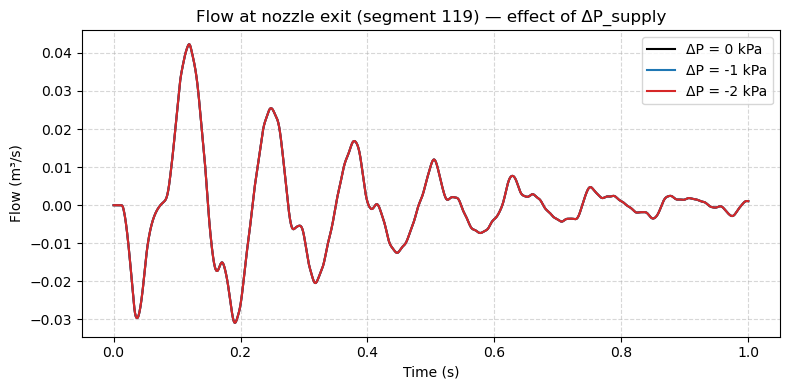

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

torch.set_default_dtype(torch.float64)

# ----------------------------  기본 상수  ----------------------------
Norm_U = 3e-4
Norm_C = 1e-10 * 3e-4
Norm_L = (3e-4) / 1e-10
Norm_R = 1 / 1e-10

partition1 = partition2 = partition3 = partition4 = 30
partition_tot = partition1 + partition2 + partition3 + partition4  # 120

sigma = 0.047
mu    = 0.0157
rho   = 1111.4
alpha = 0.29e-9
c     = 1600

r      = 235e-6
r_nozz = 25e-6
l1, l2, l3, l4 = 0.012, 0.0084, 0.00542303, 0.00057697

# ----------------------------  기하 정보  ----------------------------
T_visc = 2*(l1+l2+l3+l4)/c
delta_v = torch.sqrt(mu*T_visc/torch.tensor(math.pi)/rho)

ri = torch.tensor([r + (r_nozz-r)/partition4*i for i in range(1, partition4+1)])
ri = torch.cat([r*torch.ones(partition_tot-partition4), ri])

li = torch.cat([
    l1/partition1*torch.ones(partition1),
    l2/partition2*torch.ones(partition2),
    l3/partition3*torch.ones(partition3),
    l4/partition4*torch.ones(partition4)
])

# ----------------------------  상태공간 요소  ----------------------------
cap = (torch.pi*ri**2*li/(c**2)/rho)/Norm_C
cap[-1] = (torch.pi*r_nozz**4/(3*sigma))/Norm_C
ind = (rho*li/(torch.pi*ri**2)) / Norm_L
res = (2*mu*li/(torch.pi*delta_v*ri**3)) / Norm_R

N = partition_tot
I_N = torch.eye(N)

L_mat = torch.roll(I_N*(1/ind), -1, dims=1) - I_N*(1/ind);  L_mat[0, -1] = 0
C_mat = -torch.roll(I_N*(1/cap),  1, dims=1) + I_N*(1/cap); C_mat[-1, 0] = 0
R_mat = -I_N * (res/ind)

A_mat = L_mat @ C_mat     # q(t) 항
B_mat = R_mat             # q'(t) 항

# ====================================================================
# 1) 외력 분포 벡터  --------------------------------------------------
# ====================================================================
# (1) 시간-의존 압전(전압) 구동 : partition2 만 → B_mat1
B_mat1 = torch.cat([
    torch.zeros(partition1, 1),
    torch.ones(partition2, 1),
    torch.zeros(partition3 + partition4, 1)
], dim=0)                              # (120,1)

# (2) 공급압력 항에 공통으로 쓰이는 계수 (ΔP 제외 부분)
B_supply_base = (math.pi * ri**4) / (8 * mu * li)   # shape (120,)
B_supply_base = B_supply_base.view(-1, 1)           # (120,1)

# ====================================================================
# 2) 시간축 & 전압 파형 ----------------------------------------------
# ====================================================================
T_  = torch.linspace(0.0, 1.0, 3002)   # 0-1 s
dt  = T_[1] - T_[0]
nT  = len(T_)

t1, t2, t3, V_max = 6e-2/3, 26e-2/3, 32e-2/3, 30.0
dVdp = (
    V_max / t1 * (1 - (T_ > t1).float())
    - V_max / (t3 - t2) * ((T_ > t2).float() - (T_ > t3).float())
)

# 압전(시간 의존) 항은 ΔP_supply 와 무관하므로 한 번만 계산
f_piezo = -(-B_mat1 * (c**2) * rho * 2 * alpha * dVdp.reshape(1, -1) / r) * Norm_U

# ====================================================================
# 3) BDF-2 2차계 미분방정식 솔버 --------------------------------------
# ====================================================================
def bdf2_solver_2nd_order(A, B, f_bot, q0, qdot0, dt):
    N, nT = f_bot.shape
    q   = torch.zeros((N, nT+1));  q[:,0] = q0
    qd  = torch.zeros((N, nT+1));  qd[:,0] = qdot0

    qdd0 = A @ q0 + B @ qdot0 + f_bot[:,0]
    qd[:,1] = qdot0 + dt*qdd0
    q[:,1]  = q0    + dt*qd[:,1]

    qm2, qm1 = q0, q[:,1]
    qdm2, qdm1 = qdot0, qd[:,1]
    α = 3/(2*dt); β = 3/(2*dt); I = torch.eye(N)

    for n in range(2, nT+1):
        const_q = (-4/(2*dt))*qm1 + (1/(2*dt))*qm2
        const_d = (-4/(2*dt))*qdm1 + (1/(2*dt))*qdm2
        M = β*α*I - A - α*B
        rhs = -(β*const_q + const_d) + B @ const_q - f_bot[:,n-1]
        qn = torch.linalg.solve(M, rhs)
        qdn = α*qn + const_q

        q[:,n], qd[:,n] = qn, qdn
        qm2, qm1 = qm1, qn
        qdm2, qdm1 = qdm1, qdn
    return q, qd

# ====================================================================
# 4) ΔP_supply 3가지 시나리오 반복 돌리기 -----------------------------
# ====================================================================
pressures = [0.0, -1_000.0, -2_000.0]   # 0, -1 kPa, -2 kPa  (Pa 단위)
colors    = ["k", "tab:blue", "tab:red"]
labels    = ["ΔP = 0 kPa", "ΔP = -1 kPa", "ΔP = -2 kPa"]

idx_plot = 119            # 노즐 출구 세그먼트
q_results = []

for ΔP, col, lab in zip(pressures, colors, labels):
    # 공급압력 항
    B_mat2 = B_supply_base * ΔP                     # (120,1)
    f_supply = B_mat2.repeat(1, nT)                 # → (120,nT)
    f_1st_total = f_piezo + f_supply
    f_2nd_bot = L_mat @ f_1st_total

    q0 = torch.zeros(N); qdot0 = torch.zeros(N)
    q_sol, _ = bdf2_solver_2nd_order(A_mat, B_mat, f_2nd_bot, q0, qdot0, dt)
    q_results.append(q_sol[idx_plot,1:].detach().cpu().numpy())

# ====================================================================
# 5) 결과 플롯 --------------------------------------------------------
# ====================================================================
plt.figure(figsize=(8,4))
for q_curve, col, lab in zip(q_results, colors, labels):
    plt.plot(T_.numpy(), q_curve, col, label=lab, linewidth=1.5)

plt.title("Flow at nozzle exit (segment 119) — effect of ΔP_supply")
plt.xlabel("Time (s)")
plt.ylabel("Flow (m³/s)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


q_sol.shape = torch.Size([120, 3003])
qdot_sol.shape = torch.Size([120, 3003])


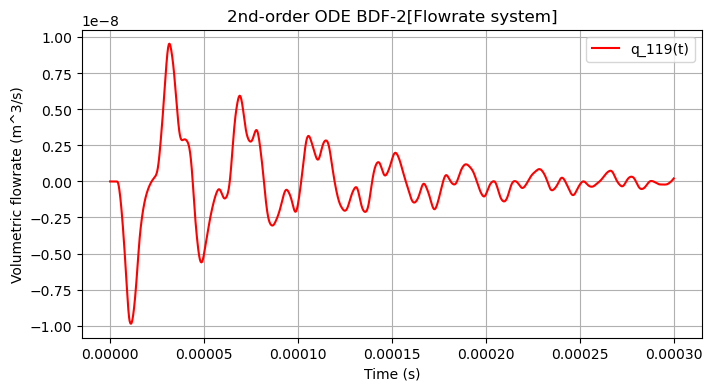

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

# --------------------------------
# 0) Basic constants and settings
# --------------------------------
torch.set_default_dtype(torch.float64)

# ----------------------------
# Normalization factors
# ----------------------------

partition1, partition2, partition3, partition4  = 30, 30, 30, 30
partition_tot = partition1 + partition2 + partition3 + partition4  # 120

sigma = 0.047
mu    = 0.0157
rho   = 1111.4
alpha = 0.29e-9
c     = 1600

r      = 235e-6
r_nozz = 25e-6
l1 = 0.012
l2 = 0.0084
l3 = 0.00542303
l4 = 0.00057697

# Characteristic time considering viscous effects
T_visc = 2*(l1 + l2 + l3 + l4)/c
delta_v = torch.sqrt(mu * T_visc / torch.tensor(math.pi) / rho)

# 1) Dividing radius and length by segment
ri = torch.tensor([r + (r_nozz - r)/partition4 * i for i in range(1, partition4+1)])
ri = torch.cat([r*torch.ones(partition_tot - partition4), ri])
li = torch.cat([
    l1/partition1*torch.ones(partition1),
    l2/partition2*torch.ones(partition2),
    l3/partition3*torch.ones(partition3),
    l4/partition4*torch.ones(partition4)
])

# 2) State-space elements (cap, ind, res)
cap = (torch.pi*(ri**2)*li/(c**2)/rho)
cap[-1] = (torch.pi*(r_nozz**4)/3/sigma)

ind = (rho*li/torch.pi/(ri**2))
res = (2*mu*li/torch.pi/delta_v/(ri**3))

# 3) Matrices needed for "second-order" differential equation
#    q''(t) = A * q(t) + B * q'(t) + f(t)
#    Here, A = L_mat * C_mat, B = R_mat
#
#    L_mat, C_mat, R_mat are constructed as follows
partition_N = partition_tot

# eye, zeros
I_N = torch.eye(partition_N)
Z_N = torch.zeros((partition_N, partition_N))

# L_mat
L_mat = torch.roll(I_N*(1.0/ind), -1, dims=1) - I_N*(1.0/ind)
L_mat[0, -1] = 0

# C_mat
C_mat = -torch.roll(I_N*(1.0/cap), 1, dims=1) + I_N*(1.0/cap)
C_mat[-1, 0] = 0

# R_mat
R_mat = -I_N*(res/ind)

A_mat = L_mat @ C_mat   # Term multiplied by q(t)
B_mat = R_mat           # Term multiplied by q'(t)


# 4) External force f(t) = f_2nd_bot
#    In the original code, f_2nd = [ 0; L_mat @ f_1st ]
#    ⇒ For our direct use, f_2nd_bot = L_mat @ f_1st
B_q_bot = torch.cat([
    torch.zeros(partition1,1),
    torch.ones(partition2,1),
    torch.zeros(partition3+partition4,1)
], dim=0)

T_ = torch.linspace(0, 3e-4, 3002)  # 0 to 1 second, 3001 steps + 1
dt = T_[1] - T_[0]
nT = len(T_)

t1, t2, t3, V_max = 6e-6, 26-6, 32e-6, 30
dVdp = (
    V_max/t1*(1 - (T_ > t1).float())
    - V_max/(t3 - t2)*((T_ > t2).float() - (T_ > t3).float())
)

f_1st = -(-B_q_bot*(c**2)*rho*2*alpha*dVdp.reshape(1,-1)/r) 
f_2nd_bot = L_mat @ f_1st  # (N, nT)

# 5) Initial conditions: q(0) & q'(0)
q_init   = torch.zeros(partition_N)
qdot_init= torch.zeros(partition_N)  # According to the problem setup, initial flow velocity = 0

# ----------------------------------------------------
# 6) (Important) Direct BDF-2 recursive function for a second-order differential system
# ----------------------------------------------------
def bdf2_solver_2nd_order(A, B, f_bot, q0, qdot0, dt):
    """
    Example function for directly solving the 2nd-order ODE
    q''(t) = A q(t) + B q'(t) + f(t)
    using BDF-2.

    Parameters
    ----------
    A : torch.Tensor, shape=(N,N)
    B : torch.Tensor, shape=(N,N)
    f_bot : torch.Tensor, shape=(N, nT)  # Forced term (vector) at each time
    q0 : torch.Tensor, shape=(N,)       # Initial q(0)
    qdot0 : torch.Tensor, shape=(N,)    # Initial q'(0)
    dt : float

    Returns
    -------
    q_hist : (N, nT+1)      # q(t_n) at each step
    qdot_hist : (N, nT+1)   # q'(t_n) at each step
    """
    N, nT = f_bot.shape
    # For storing results
    q_hist    = torch.zeros((N, nT+1), dtype=A.dtype, device=A.device)
    qdot_hist = torch.zeros((N, nT+1), dtype=A.dtype, device=A.device)

    # Record the initial conditions
    q_hist[:, 0]    = q0
    qdot_hist[:, 0] = qdot0

    # The first step (t=dt) requires x_{-1} for BDF-2
    # Usually, "2nd-order implicit integration" (or another 1-step method) is used to approximate q_1, qdot_1
    # Here, we simply try a "Backward Euler"-like approach for q_1:
    #   q''(t_0) ~ A q0 + B qdot0 + f(0)
    #   q'(t_0+dt) ~ qdot0 + dt*q''(t_0)
    #   q(t_0+dt)  ~ q0 + dt*q'(t_0+dt)
    f0       = f_bot[:, 0]  # shape=(N,)
    qddot0   = A @ q0 + B @ qdot0 + f0
    qdot_1   = qdot0 + dt * qddot0
    q_1      = q0 + dt * qdot_1

    q_hist[:, 1]    = q_1
    qdot_hist[:, 1] = qdot_1

    # Now, apply BDF-2 in earnest
    # BDF-2:
    #   (3 x_n - 4 x_{n-1} + x_{n-2}) / (2dt) = x'_n
    #   (3 x'_n - 4 x'_{n-1} + x'_{n-2}) / (2dt) = x''_n
    #
    # where x=q, x'=q', x''=q''= A q + B q' + f
    #
    # => We must formulate the equation for q_n (implicit).
    #    (Here, a straightforward direct approach is shown.)
    
    # Store previous steps
    q_nm2    = q0
    q_nm1    = q_1
    qdot_nm2 = qdot0
    qdot_nm1 = qdot_1

    # Time loop
    for i_step in range(2, nT+1):
        # External force at this step
        f_i = f_bot[:, i_step-1]  # shape=(N,)

        # Unknowns to solve for: q_n and qdot_n
        # 
        # (1) BDF-2 approximation: qdot_n = (3 q_n - 4 q_{n-1} + q_{n-2}) / (2dt)
        # (2) Another BDF-2 approximation: q''_n = (3 qdot_n - 4 qdot_{n-1} + qdot_{n-2}) / (2dt)
        #                                = A q_n + B qdot_n + f_i
        #
        # By combining the above, we can obtain a matrix form in q_n.
        #
        # (See the comments below for more detailed steps.)
        
        # 1) qdot_n = (3/2dt)*q_n + constant
        alpha   = 3.0/(2.0*dt)
        const_q = (-4.0/(2.0*dt))*q_nm1 + (1.0/(2.0*dt))*q_nm2

        # 2) q''_n = A q_n + B qdot_n + f_i
        #    Another BDF-2 form:
        #    q''_n = (3 qdot_n - 4 qdot_nm1 + qdot_nm2) / (2 dt)
        beta    = 3.0/(2.0*dt)
        const_d = (-4.0/(2.0*dt))*qdot_nm1 + (1.0/(2.0*dt))*qdot_nm2

        # Then:
        #   (3 qdot_n - 4 qdot_nm1 + qdot_nm2)/(2 dt) = A q_n + B qdot_n + f_i
        #
        #   beta*(alpha q_n + const_q) + const_d = A q_n + B*(alpha q_n + const_q) + f_i
        #   => (beta*alpha) q_n + beta*const_q + const_d = A q_n + B*alpha q_n + B*const_q + f_i
        #
        #   Collect terms in q_n:
        #   (beta*alpha - A - B*alpha) q_n = - (beta * const_q + const_d) + B*const_q - f_i
        #
        #   M_q = beta*alpha * I - A - alpha*B
        #   rhs = - (beta * const_q + const_d) + B@const_q - f_i
        #
        M_q  = beta*alpha * I_N - A - alpha*B
        rhs  = - (beta * const_q + const_d) + (B @ const_q) - f_i

        # Solve for q_n = M_q^-1 * rhs
        q_n = torch.linalg.solve(M_q, rhs)

        # qdot_n = alpha * q_n + const_q
        qdot_n = alpha * q_n + const_q

        # Save in storage
        q_hist[:, i_step]    = q_n
        qdot_hist[:, i_step] = qdot_n

        # Use the current step results as past values for the next loop
        q_nm2    = q_nm1
        q_nm1    = q_n
        qdot_nm2 = qdot_nm1
        qdot_nm1 = qdot_n

    return q_hist, qdot_hist


# -----------------------------------------------------
# 7) Solve the second-order ODE using BDF-2
# -----------------------------------------------------
q_sol, qdot_sol = bdf2_solver_2nd_order(
    A_mat, B_mat, f_2nd_bot,
    q_init, qdot_init, dt
)

print("q_sol.shape =", q_sol.shape)       # (N, nT+1), N=120, nT=3002
print("qdot_sol.shape =", qdot_sol.shape) # (N, nT+1)

# 8) Example: plot the flow at a specific index
i_q = 119
q_2nd_all = q_sol[i_q, :].detach().cpu().numpy()  # length = nT+1 = 3003
# Exclude the very first value (q(0)) and consider from t=dt
q_2nd = q_2nd_all[1:]   # (3002 elements)

T_plot = T_.numpy()     # 3002 time points, including the initial 0s
plt.figure(figsize=(8,4))
plt.plot(T_plot, q_2nd, 'r-', label=f"q_{i_q}(t)")
plt.title("2nd-order ODE BDF-2[Flowrate system]")
plt.xlabel("Time (s)")
plt.ylabel("Volumetric flowrate (m^3/s)")
plt.grid(True)
plt.legend()
plt.show()
